# **FantaBayesianNet: a Bayesian Network to make inference on individual performance in football**

***Fundamentals of Artificial Intelligence and Knowledge Representation (Mod. 3) - Alma Mater Studiorum Università di Bologna***

*Authors:*
- Giuseppe	Boezio	(0001005271 $-$ giuseppe.boezio@studio.unibo.it)
- Giuseppe	Murro	(0000997317 $-$ giuseppe.murro@studio.unibo.it)
- Salvatore	Pisciotta	(0000985203 $-$ salvatore.pisciotta2@studio.unibo.it)

## **Abstract**
This notebook explains the work done and the results achieved in the Knowledge Representation class project,
specifically in the module about uncertainty and probabilistic reasoning, held by professor Paolo Torroni.

The task of predicting the performance of football players is gaining increasing
attention in the sports and statistical communities. In this work, we used a Bayesian Network to model relevant factors of player performance in the
presence of noisy data. We apply our analysis to the 2020–2021 season in the top Italian league, Serie A, and use the player ratings provided by a popular Italian fantasy football game, the so-called *Fantacalcio*.

Our central goals are to explore what are the causal relations that allow to predict if a football player can be deployed or not in a fantasy football lineup. Different kind of reasoning are done to exploit the flows of influence between variables and possible independences.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
!{sys.executable} -m pip install pgmpy

     |████████████████████████████████| 337kB 7.0MB/s 


In [3]:
!rm "/usr/local/lib/python3.7/dist-packages/pgmpy/sampling/Sampling.py"

In [4]:
import time
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

%matplotlib inline

from pgmpy.estimators import BayesianEstimator
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
import networkx as nx

## **1. Data preprocessing**
The first step consists in load data, merge different dataframes to get a single dataframe of players and process feature in order to work with them.

Since statistics of single football players of Serie A in each mach are not directly accessible and they are distributed on different web sites, we have developed a *web scraping script* (accessible from the [repository](https://github.com/giuseppeboezio/FantaBayesianNet/blob/main/src/ScrapingPlayer.py)) able to collect data from [*Fantacalcio.it*](https://www.fantacalcio.it/statistiche-serie-a) and [*Transfermarket.it*](https://www.transfermarkt.it/serie-a/startseite/wettbewerb/IT1). 

We decided to select only **forwards**, since their statistics are the most interesting from the view point of the *Fantacalcio*, and we picked an average of 2 players per team for a total of 40 players. 

These data are about the first 30 rounds of the 2020–2021 Serie A season.

In [5]:
!git clone https://github.com/giuseppeboezio/FantaBayesianNet.git

Cloning into 'FantaBayesianNet'...
remote: Enumerating objects: 660, done.
remote: Counting objects: 100% (660/660), done.
remote: Compressing objects: 100% (450/450), done.
remote: Total 660 (delta 254), reused 603 (delta 200), pack-reused 0
Receiving objects: 100% (660/660), 8.55 MiB | 13.29 MiB/s, done.
Resolving deltas: 100% (254/254), done.


In [6]:
!mv "/content/FantaBayesianNet/src/Sampling.py" "/usr/local/lib/python3.7/dist-packages/pgmpy/sampling"

In [7]:
data_dir= "FantaBayesianNet/data" 

In [8]:
list_files = sorted(
    [
        os.path.join(data_dir, fname)
        for fname in os.listdir(data_dir)
        if fname.endswith(".csv")
    ]
)


players = []

for file in list_files:
  players.append(pd.read_csv(file))

df = pd.concat(players)
df

,matchday,date,home_team_pos,home_team,away_team_pos,away_team,result,available,goal,assist,autogoal,yellow_card,double_yellow_card,red_card,substitution_on,substitution_off,minutes,penalty_kicker,home_match,score,grade,penalty_scored,penalty_kick,starter,postponed,difficulty_match,deployability
0,3,02/ott/2020,9,Fiorentina,18,Sampdoria,1:2,non convocato,0,0,0,False,False,False,NaN,NaN,0,False,False,NaN,NaN,0,0,False,False,3,False
1,4,17/ott/2020,14,Sampdoria,9,Lazio,3:0,Available,0,0,0,False,False,False,79.0,NaN,11,False,True,NaN,NaN,0,0,False,False,3,False
2,5,24/ott/2020,4,Atalanta,9,Sampdoria,1:3,Available,0,1,0,True,False,False,66.0,NaN,24,False,False,6.5,6.0,0,0,False,False,4,False
3,6,01/nov/2020,7,Sampdoria,17,Genoa,1:1,Available,0,0,0,False,False,False,66.0,NaN,24,False,True,6.5,6.5,0,0,False,False,2,True
4,7,07/nov/2020,12,Cagliari,9,Sampdoria,2:0,Problema muscolare,0,0,0,False,False,False,NaN,NaN,0,False,False,NaN,NaN,0,0,False,False,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,26,07/mar/2021,20,Crotone,17,Torino,4:2,Available,0,0,0,False,False,False,NaN,65.0,65,False,False,4.0,4.0,0,0,True,False,3,False
25,27,14/mar/2021,17,Torino,1,Inter,1:2,Available,0,0,0,False,False,False,67.0,NaN,23,False,True,6.0,6.0,0,0,False,False,5,False
26,28,21/mar/2021,11,Sampdoria,17,Torino,1:0,Available,0,0,0,False,False,False,59.0,NaN,31,False,False,6.0,6.0,0,0,False,False,4,False
27,29,03/apr/2021,17,Torino,3,Juventus,2:2,Available,0,0,0,False,False,False,72.0,NaN,18,False,True,6.0,6.0,0,0,False,False,5,False


In the *raw dataset* we have a lot of data, but only some of them are useful for our model.
So in the following cell we have to do:
- **data cleaning** from useless columns and rows that refers to `postponed` matches
- **data discretization** since pgmpy does not support learning from continuous variable, and so all numerical values are mapped into bins
- transform *NaN values* from the `score` into the category "sv", which is more meaningful from the Fantacalcio viewpoint

<br>

The meaning and the values that each **variable** selected from the database can assume is the following:
<ul>
    <li><b>goal</b> = Goal: represents whether, at the correspondent matchday, the player has made a goal and obtained the correspondent bonus(+3)</li>
        <ul>
            <li>True: the player has scored at least one goal</li>
            <li>False: The player didn't even score one goal</li>
        </ul>
    <li><b>assist</b> = Assist: represents whether, at the correspondent matchday, the player has made an assist and obtained the correspondent bonus(+3)</li>
        <ul>
            <li>True: The player has made at least one assist</li>
            <li>False: The player didn't even make one assist</li>
        </ul>
    <li><b>time_range</b> = Range of minutes: minutes played by the player in the correspondent matchday(min=0 minutes, max=90 minutes) </li>
        <ul>
            <li>0-15: The player played no more than 15 minutes</li>
            <li>16-45: The player has played more than 15 minutes but less than 45 minutes</li>
            <li>46-90: The player has played more than 45 minutes</li>
        </ul>
    <li><b>score_range</b> = Range of "fantasy score": fantasy score obtained by the player at the correspondent matchday, with appropriate bonus and malus included </li>
        <ul>
            <li>s.v.: The player has not played or has played too little time to have a vote</li>
            <li><=5: the player had a bad game with some possibile malus </li>
            <li>5.5-6.5: the player did not play a great game or at most a sufficient game </li>
            <li>7-9.5: the player played a great game and may have taken some bonuses as well </li>
            <li>>=10: the player played an excellent game and also took some bonuses </li>
        </ul>
        <li><b>difficulty_match</b> = Difficulty of the match calculated in crescent order through a formula</li>
        <ul>
            <li>1: easy match generally played at home</li>
            <li>2: easy match generally played away</li>
            <li>3: balanced match </li>
            <li>4: difficult match generally played at home</li>
            <li>5: difficult match generally played away </li>
        </ul>
        <li><b>penalty_kicker</b>= Kicker of the team for penalties: represents whether the player (if at the correspondent matchday was avaiable) is the one designed to kick the penalties</li>
        <ul>
            <li>True: The player is the penalty kicker</li>
            <li>False:The player isn't the penalty kicker</li>
        </ul>
        <li><b>home_match</b> = : represents whether, at the correspondent matchday, the player's team played at home or away </li>
        <ul>
            <li>True: the team played the match at home</li>
            <li>False: the team played the match away from home</li>
        </ul>
        <li><b>yellow_card</b> = Admonition: represents whether, at the correspondent matchday, the player the player got a yellow card with correspondent malus(-0.5) </li>
        <ul>
            <li>True: the player received a yellow card</li>
            <li>False: the player didn't receive a yellow card</li>
        </ul>
        <li><b>red_card</b> = Expulsion: represents whether, at the correspondent matchday, the player the player got a red card with correspondent malus(-1) </li>
        <ul>
            <li>True: the player received a red card</li>
            <li>False: the player didn't receive a red card</li>
        </ul>
        <li><b>avaiable</b> = Availability: represent whether the player at the corresponding matchday was available for his team or not (e.g. for an injury or a 
disqualification)</li>
        <ul>
            <li>True: the player was avaiable</li>
            <li>False: the player wasn't avaiable</li>
        </ul>
        <li><b>deployability</b> = Deployability: represents whether the player for the corresponding matchday will be a good choice for the fantasy team of the fantasy manager</li>
        <ul>
            <li>True: deploy the player is a good choice</li>
            <li>False: it is better, if possible, not to deploy the player</li>
        </ul>

</br>











In [9]:
# remove postponed matches
df.drop(df[df['postponed'] == True].index, inplace=True)

# change available in True/False
df['available'] = df['available'].apply(lambda x : True if x == 'Available' else False)

# change goal in True/False
df['goal'] = df['goal'].apply(lambda x: True if x > 0 else False)

# change assist in True/False
df['assist'] = df['assist'].apply(lambda x: True if x > 0 else False)

# change minutes into ranges [0-15], [16-45], [46-90]
bins = [0, 16, 46, 95]
labels = ['0-15', '16-45', '46-90']
df['time_range'] = pd.cut(df['minutes'], bins=bins, labels=labels, right=False)

# change scores into sv, '<=5', '5.5-6.5', '7-9.5', '>=10'
df['score'].fillna(value=-5, inplace=True)
bins = [-5, -4, 5.5, 7, 10, 25]
labels = ['sv', '<=5', '5.5-6.5', '7-9.5', '>=10']
df['score_range'] = pd.cut(df['score'],  bins=bins, labels=labels, right=False)

# only columns needed
variables = ['penalty_kicker', 'goal', 'assist', 'yellow_card', 'red_card', 'available', 'starter', 'time_range', 'score_range', 'difficulty_match', 'deployability','home_match']
df = df[variables]
df

,penalty_kicker,goal,assist,yellow_card,red_card,available,starter,time_range,score_range,difficulty_match,deployability,home_match
3,False,False,False,False,False,True,False,16-45,5.5-6.5,2,True,True
4,False,False,False,False,False,False,False,0-15,sv,2,False,False
5,False,False,False,False,False,False,False,0-15,sv,2,False,True
6,False,False,False,False,False,False,False,0-15,sv,2,False,False
7,False,False,False,False,False,False,False,0-15,sv,4,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
22,False,False,False,False,False,True,True,46-90,<=5,3,False,False
24,False,False,False,False,False,True,True,46-90,<=5,3,False,False
25,False,False,False,False,False,True,False,16-45,5.5-6.5,5,False,True
26,False,False,False,False,False,True,False,16-45,5.5-6.5,4,False,False


In [10]:
df.dtypes

penalty_kicker          bool
goal                    bool
assist                  bool
yellow_card             bool
red_card                bool
available               bool
starter                 bool
time_range          category
score_range         category
difficulty_match       int64
deployability           bool
home_match              bool
dtype: object

Correlation matrix has been used to understand whether flow of influence among variables were meaningful.

In [11]:
# Transforming ordinal variables in order to investigate about them

ordinal_features =['time_range', 'score_range']
ordinal_transformer = OrdinalEncoder(dtype = np.int32)
preprocessor = ColumnTransformer(
    transformers = [
                    ('ord', ordinal_transformer, ordinal_features)
                   ],
                    remainder = 'passthrough'  # with 'passthrough' the non-specified columns in transformers will be automatically passed through                       
    )

preprocessor.fit(df)

df_p = preprocessor.fit_transform(df)
columns= ['time_range', 'score_range', 'penalty_kicker', 'goal', 'assist', 'yellow_card', 'red_card', 'available', 'starter', 'difficulty_match', 'deployability','home_match']

# Conversion on dataframe for all players
df_p = pd.DataFrame(df_p, columns=columns).convert_dtypes()

# Checking types
print(df_p.dtypes)

time_range            Int64
score_range           Int64
penalty_kicker      boolean
goal                boolean
assist              boolean
yellow_card         boolean
red_card            boolean
available           boolean
starter             boolean
difficulty_match      Int64
deployability       boolean
home_match          boolean
dtype: object


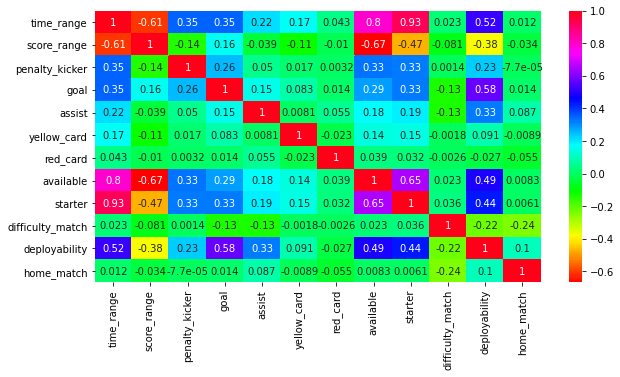

In [12]:
plt.figure(figsize=(10,5))
sns.heatmap(df_p.corr(), annot=True, cmap='hsv')
plt.show()

Show histograms for all varibles in the dataset to understand their distribution

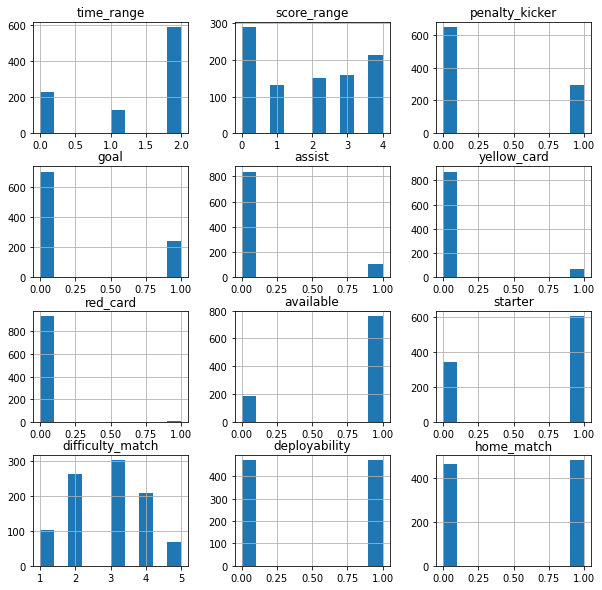

In [13]:
pd.DataFrame.hist(df_p.astype('int')
                  , figsize = [10,10]
                 );

## **2. Define the model**
The second step consists in building the structure of our model, that is to define the relations between the involved variables.
In the following lines we define the network model using pgmpy library and then we display the resulting graph using networkx.

In [14]:
model = BayesianModel([('available', 'starter'),
                       ('starter', 'time_range'),
                       ('time_range', 'red_card'),
                       ('time_range', 'yellow_card'),
                       ('time_range', 'goal'),
                       ('time_range', 'assist'),
                       ('available', 'penalty_kicker'),
                       ('penalty_kicker', 'goal'),
                       ('red_card', 'score_range'),
                       ('yellow_card', 'score_range'),
                       ('goal', 'score_range'),
                       ('assist', 'score_range'),
                       ('difficulty_match', 'deployability'),
                       ('score_range', 'deployability'),
                       ('home_match','difficulty_match')
                       ])

#Network nodes and out-edges
nodes = list(model.nodes())
edges = list(model.edges())
print("Nodes:", nodes)
print("\nOutEdges:", edges)

Nodes: ['available', 'starter', 'time_range', 'red_card', 'yellow_card', 'goal', 'assist', 'penalty_kicker', 'score_range', 'difficulty_match', 'deployability', 'home_match']

OutEdges: [('available', 'starter'), ('available', 'penalty_kicker'), ('starter', 'time_range'), ('time_range', 'red_card'), ('time_range', 'yellow_card'), ('time_range', 'goal'), ('time_range', 'assist'), ('red_card', 'score_range'), ('yellow_card', 'score_range'), ('goal', 'score_range'), ('assist', 'score_range'), ('penalty_kicker', 'goal'), ('score_range', 'deployability'), ('difficulty_match', 'deployability'), ('home_match', 'difficulty_match')]


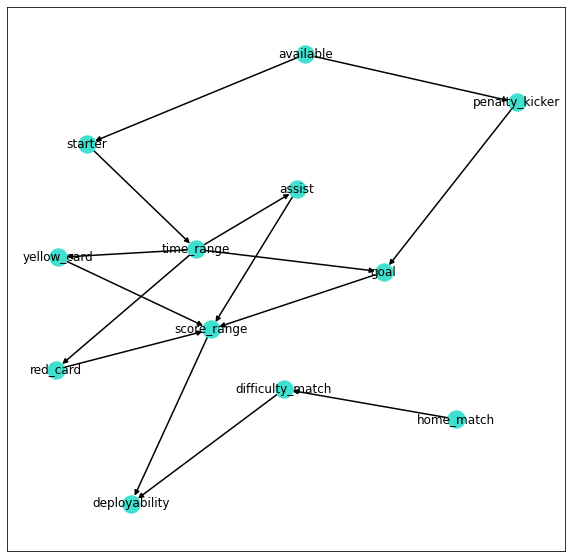

In [15]:
np.random.seed(34)

DAG = nx.DiGraph()
DAG.add_edges_from(edges)

fig = plt.figure(figsize = (10,10))
pos = nx.spring_layout(DAG) #Position nodes computed by using Fruchterman-Reingold force-directed algorithm.
nx.draw_networkx_nodes(DAG, pos=pos, node_color='turquoise')
nx.draw_networkx_labels(DAG, pos=pos)
nx.draw_networkx_edges(DAG, pos=pos, edge_color='black', width = 1.5, arrows=True)
plt.show()

## **3. Learning of network parameters**
In pgmpy it is possible to **learn the CPT** of a given Bayesian network using either a Bayesian Estimator or a Maximum Likelihood Estimator (MLE). The former exploits a known prior distribution of data, the latter does not make any particular assumption.

The *MLE* can overfit the data in case of small datasets, because there can be not enough observations and thus the observed frequencies can be not representative. Another problem with MLE is the fact that state counts are done conditionally for each parents configuration and this causes immense fragmentation since the state counts drop even more. 

The *Bayesian Estimator* instead does not only rely on input data to learn the network parameters, but it also takes advantage of a prior knowledge, expressed through a prior distribution. In this way, the estimator does not have an absolute guide, but rather a reasonable starting assumption that allows to counterbalance the lack of data.

Although the MLE approach seems plausible, it can be overly simplistic in many cases, whereas the Bayesian one is intrinsically more robust. As a consequence the Bayesian Estimator is choosen.

There are several prior distribuitions available in pgmpy, a sensible choice of prior is the Bayesian Dirichlet equivalent uniform prior (BDeu). In the learning process, using BDeu, N uniform samples are generated for each variable to compute the pseudo-counts (default is N=5), hence the estimated probabilities in CPT are more conservative than the ones obtained through MLE (i.e. probabilities close to 1 or 0 get smoothed).

In the following cell the CPT are learned and displayed.

In [16]:
from IPython.core.display import display, HTML

# disable text wrapping in output cell
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

model.cpds = []
model.fit(  data=df
          , estimator=BayesianEstimator
          , prior_type="BDeu"
          , equivalent_sample_size=10
          ,complete_samples_only=False)

print(f'Check model: {model.check_model()}\n')
for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')


Check model: True

CPT of available:
+------------------+----------+
| available(False) | 0.196017 |
+------------------+----------+
| available(True)  | 0.803983 |
+------------------+----------+ 

CPT of starter:
+----------------+----------------------+---------------------+
| available      | available(False)     | available(True)     |
+----------------+----------------------+---------------------+
| starter(False) | 0.9866310160427807   | 0.20795306388526727 |
+----------------+----------------------+---------------------+
| starter(True)  | 0.013368983957219251 | 0.7920469361147328  |
+----------------+----------------------+---------------------+ 

CPT of time_range:
+-------------------+----------------------+----------------------+
| starter           | starter(False)       | starter(True)        |
+-------------------+----------------------+----------------------+
| time_range(0-15)  | 0.6676356589147286   | 0.00273224043715847  |
+-------------------+----------------------+

## **4. Network Analysis**

Pgmpy allows to easily investigate the properties of the network, indeed it is possible to individuate flows of probabilistic influence, active trials, check the conditionals independence relations between features of the Bayesian network and moreover. In the following cells it is possible to notice these characteristics:
- **Markov blanket**
- **reasoning patterns** and **active trails**
- **indipendences**

### **4.1 Markov blanket**
The **Markov blanket** of a given node consists in the set of parents, children, and children's parents of the node. Moreover, given the Markov blanket of a node, the node itself becomes independent from any other nodes of the network.
The following cell display, for each variable, the node (turquoise) with its Markov blanket (yellow) and the remaining nodes (gray).

-------------------------------------------------------------------------------- 

available 
Markov blanket -> ['penalty_kicker', 'starter']


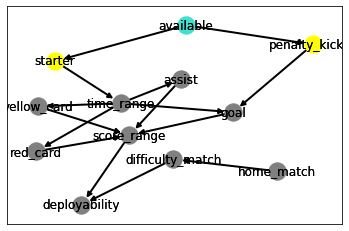

-------------------------------------------------------------------------------- 

starter 
Markov blanket -> ['available', 'time_range']


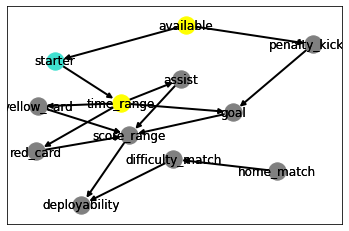

-------------------------------------------------------------------------------- 

time_range 
Markov blanket -> ['red_card', 'assist', 'goal', 'starter', 'yellow_card', 'penalty_kicker']


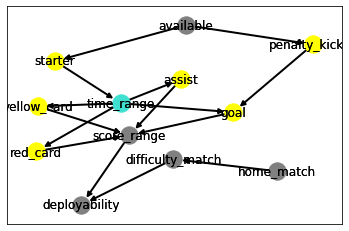

-------------------------------------------------------------------------------- 

red_card 
Markov blanket -> ['assist', 'goal', 'time_range', 'yellow_card', 'score_range']


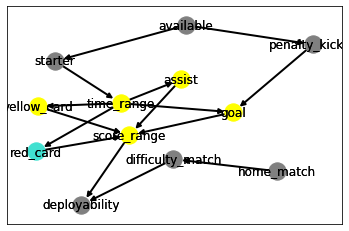

-------------------------------------------------------------------------------- 

yellow_card 
Markov blanket -> ['red_card', 'assist', 'goal', 'time_range', 'score_range']


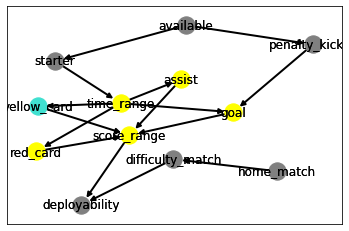

-------------------------------------------------------------------------------- 

goal 
Markov blanket -> ['red_card', 'assist', 'time_range', 'yellow_card', 'penalty_kicker', 'score_range']


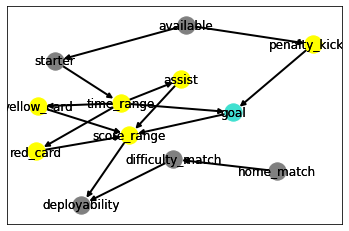

-------------------------------------------------------------------------------- 

assist 
Markov blanket -> ['red_card', 'goal', 'time_range', 'yellow_card', 'score_range']


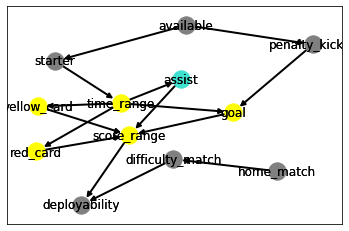

-------------------------------------------------------------------------------- 

penalty_kicker 
Markov blanket -> ['available', 'goal', 'time_range']


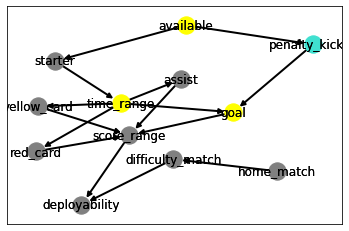

-------------------------------------------------------------------------------- 

score_range 
Markov blanket -> ['red_card', 'assist', 'difficulty_match', 'goal', 'deployability', 'yellow_card']


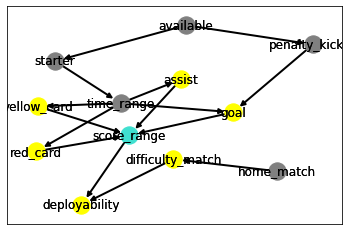

-------------------------------------------------------------------------------- 

difficulty_match 
Markov blanket -> ['home_match', 'score_range', 'deployability']


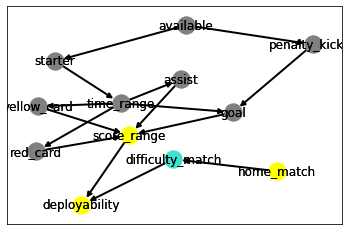

-------------------------------------------------------------------------------- 

home_match 
Markov blanket -> ['difficulty_match']


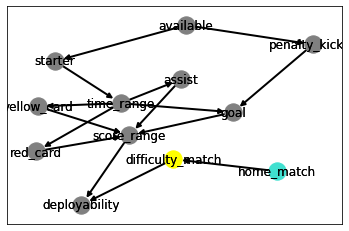

In [17]:
leaves = model.get_leaves()
markov_blanket = {}

for node in nodes:
    if not node in leaves:
        markov_blanket[node] = model.get_markov_blanket(node)
        print("-"*80,"\n")
        print(node, "\nMarkov blanket ->", markov_blanket[node])
        
        nx.draw_networkx_nodes(DAG, pos, nodelist=[node], node_color='turquoise')
        nx.draw_networkx_nodes(DAG, pos, nodelist=markov_blanket[node], node_color='yellow')
        nx.draw_networkx_nodes(DAG, pos, 
               nodelist = [n for n in nodes if n not in markov_blanket[node] and n != node], 
               node_color='grey')
        nx.draw_networkx_labels(DAG, pos)
        nx.draw_networkx_labels(DAG, pos)
        nx.draw_networkx_edges(DAG, pos, edge_color='black', width = 2.0, arrows=True)
        plt.show()

### **4.2 Reasoning patterns and active trails**

In the following cells are shown some examples of reasoning patterns, namely *causal reasoning* and *evidential reasoning*, and possibile **active-trails** in the directed graph. A trial X⇌Z⇌Y is active if influence can flow from X to Y via Z.

In [18]:
def show_active_trail(model, start, end, evidences={}, trail_to_show=[]):

  str_evidences = "| " if len(evidences) > 0 else  ""
  for evidence, value in evidences.items():
    str_evidences += evidence +"="+str(value)
    if evidence != list(evidences.keys())[-1]:  # check wheter it is last
      str_evidences += ", "
  
  title_inference = "P( {} {})".format(end, str_evidences)

  # prepare figure
  fig = plt.figure(figsize=(15,5))
  ax1, ax2 = fig.subplots(nrows=1, ncols=2)

  # compute query
  inference = VariableElimination(model)
  query = inference.query(variables=[end]
                        , evidence=evidences
                        ,show_progress=False
                        )
  
  probabilities = ["{:.4}%".format(value) for value in query.values]
  table = np.column_stack((query.state_names[query.variables[0]], probabilities))

  # plot inference 
  font_size=14
  bbox=[0, 0, 1, 0.60]
  mpl_table = ax1.table(cellText = table
                      , bbox=bbox
                      , cellLoc='center'
                      , colLabels=query.variables+[ "P({} | .. )".format(end)]
                      , colWidths=[1.5, 2]
                      , loc = 'center'
                      , colColours=['#d9d9d9','#d9d9d9'])
  mpl_table.auto_set_font_size(False)
  mpl_table.set_fontsize(font_size)
  ax1.axis('off')
  ax1.set_title(title_inference)
  
  # check if there is an active trail
  obs = list(evidences.keys()).remove(start) if start in list(evidences.keys()) else list(evidences.keys())
  active = model.is_active_trail(start=start, end=end, observed=obs)
  title_graph = "ACTIVE TRAIL ({} -> {}): {}".format(start, end, active)

  edges = list(model.in_edges(trail_to_show))
  trail_edges = edges.copy() 

  # remove unuseful edge
  edges = list(model.in_edges(trail_to_show))
  trail_edges = edges.copy()

  for edge in edges:
    if not all(node in trail_to_show for node in edge):
      trail_edges.remove(edge)

  # plot graph 
  nx.draw_networkx_edges(DAG, pos, edge_color='gray', width = 2.0, arrows=True, ax=ax2)
  nx.draw_networkx_nodes(DAG, pos, nodelist = nodes, node_color='white', edgecolors='grey', ax=ax2)
  nx.draw_networkx_edges(DAG, pos, edgelist=trail_edges, edge_color='black', width = 2.0, arrows=True, ax=ax2)
  nx.draw_networkx_nodes(DAG, pos, nodelist=[start, end], node_color='red',  edgecolors='grey', ax=ax2)
  nx.draw_networkx_nodes(DAG, pos, nodelist=list(evidences.keys()), node_color='yellow', edgecolors='grey', ax=ax2)
  nx.draw_networkx_labels(DAG, pos, ax=ax2)
  
  ax2.set_title(title_graph) 

  plt.show()

The first example consists in showing how **$P(deployability)$** is influenced by **available** because there is an active trail between the two variables and there is no evidence or V structure that can break it.

Then, it can be shown that **starter** in the evidence behaves as a blocking node breaking an active trail between the two aforementioned variables.

In both cases there is a flow of influence because the graph is **multiply connected** i.e. there is more than one trail which connects two nodes.



CAUSAL REASONING


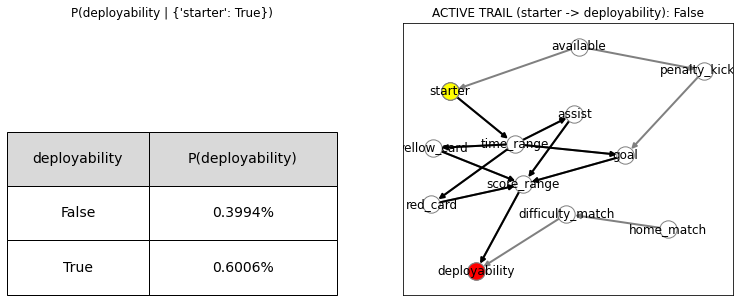

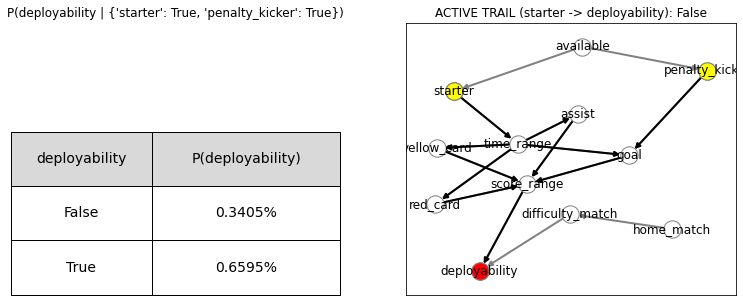

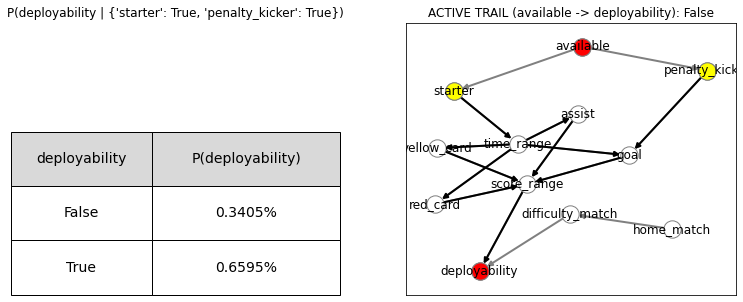

In [19]:
# Causal reasoning
print("CAUSAL REASONING:\n")

show_active_trail(model
                  , start='available'
                  , end='deployability'
                  #, evidences={'starter': True}
                  , trail_to_show=['available','starter','penalty_kicker','starter', 'goal', 'red_card', 'yellow_card', 'assist', 'time_range','score_range', 'deployability'])

print("\n")

show_active_trail(model
                  , start='available'
                  , end='deployability'
                  , evidences={'starter': True}
                  , trail_to_show=['available','penalty_kicker', 'goal','score_range', 'deployability'])

The second example consists in showing conditional independencies between variables: **starter** and **penalty_kicker** break the two possible active trails between **avaiable** and **deployability**. This is compliant with the **d-separation principle**, that allows us to determine whether a set X of variables is independent of another set Y, given a third set Z: if there is no active trail between two variables X and Y, then X and Y are d-separated.
Thus:

<center> $P \models (avaiable \ ⟂ \ deployability \ | \ starter, \ penalty\_kicker)$</center>

This means that adding **avaiable** to the evidence gives no additional information to the query. This can be proved also comparing the two probability distributions and showing that for all combinations of values they provide the same results.

In [20]:
#Active trail broken by penalty_kicker and starter with respect to available
show_active_trail(model
                  , start='available'
                  , end='deployability'
                  , evidences={'starter':True,'penalty_kicker': True}
                  , trail_to_show=[])

print("\n")

show_active_trail(model
                  , start='available'
                  , end='deployability'
                  , evidences={'available':True,'starter':True,'penalty_kicker': True}
                  , trail_to_show=[])


 P(deployability|starter=True,penalty_kicker=True,home_match=True)
+----------------------+----------------------+
| deployability        |   phi(deployability) |
+======================+======================+
| deployability(False) |               0.3280 |
+----------------------+----------------------+
| deployability(True)  |               0.6720 |
+----------------------+----------------------+

 P(deployability|starter=True,penalty_kicker=True,home_match=False)
+----------------------+----------------------+
| deployability        |   phi(deployability) |
+======================+======================+
| deployability(False) |               0.3535 |
+----------------------+----------------------+
| deployability(True)  |               0.6465 |
+----------------------+----------------------+


In the third example we are trying to understand whether a **score range** between 7-9.5 could be due to the fact that the player made a goal or not.

It can be shown also in this case that there is a **direct cause** from **goal** to **score_range**. This means that exists an active trail between the two variables.

Looking at the probability distribution, it can be understood how the goal could be a possible explaination to the received score with a probability around 58%.

The next step is to understand whether the goal could be a good explaination even if the player got a yellow card. In this case we put in the evidence also the **yellow card** and this variable influences the goal because **score_range** allows the activation of a V-structure, thus there is an active trail between **goal** and **yellow_card**.

An interesting thing is to highlight is how the probability to have made a goal increases, probably because it is very difficult that a player can get a good score with a yellow card without a goal.





In [21]:
print("EVIDENTIAL REASONING:\n")

show_active_trail(model
                  , start='score_range'
                  , end='goal'
                  , evidences={'score_range':'7-9.5'}
                  , trail_to_show=['score_range','goal'])

print("\n")

show_active_trail(model
                  , start='yellow_card'
                  , end='goal'
                  , evidences={'score_range':'7-9.5', 'yellow_card':True}
                  , trail_to_show=['score_range', 'yellow_card', 'goal'])


 P(time_range|score_range='5.5-6.5')
+-------------------+-------------------+
| time_range        |   phi(time_range) |
+===================+===================+
| time_range(0-15)  |            0.3213 |
+-------------------+-------------------+
| time_range(16-45) |            0.1508 |
+-------------------+-------------------+
| time_range(46-90) |            0.5278 |
+-------------------+-------------------+

 P(time_range|score_range='>=10')
+-------------------+-------------------+
| time_range        |   phi(time_range) |
+===================+===================+
| time_range(0-15)  |            0.0225 |
+-------------------+-------------------+
| time_range(16-45) |            0.1020 |
+-------------------+-------------------+
| time_range(46-90) |            0.8755 |
+-------------------+-------------------+


### **4.3. Indipendences**

The **V-structure** between score_range and difficulty match allows to understand the independence between goal and difficulty match because this kind of structure breaks the only possible active trail between the two variables. In our domain this is quite reasonable becouse a good player can score a goal indipendetly by the opposing team. This means that:

<center> $P \models (goal \ ⟂ \ difficulty\_match )$</center>

It has been shown in two different ways:

1.   Showing that **P(difficulty_match|goal) = P(difficulty_match)**
2.   Using the method **is_active_trail(difficult_match,goal)** which allows to prove that there is not an active trail between the two variables. 





In [23]:
 # TODO (?) show some independences

In [24]:
# Show indipendence between goal and difficulty_match

# Show probability distributions
print(" P(difficulty_match|goal=True)")
print(inference.query(['difficulty_match']
                      ,{'goal': True},
                      show_progress=False))

print("\n")

print(" P(difficulty_match)")
print(inference.query(['difficulty_match']
                      ,{},
                      show_progress=False))

print("\n")

# Show graph with the absence of an active trail
print("Active trail between goal and difficulty_match: {}".format(model.is_active_trail('goal','difficulty_match')))

Eliminating: starter:   0%|          | 0/10 [00:00<?, ?it/s]      

 P(difficulty_match|goal=True)


Eliminating: goal:   0%|          | 0/11 [00:00<?, ?it/s]  

+---------------------+-------------------------+
| difficulty_match    |   phi(difficulty_match) |
+=====================+=========================+
| difficulty_match(1) |                  0.1101 |
+---------------------+-------------------------+
| difficulty_match(2) |                  0.2767 |
+---------------------+-------------------------+
| difficulty_match(3) |                  0.3187 |
+---------------------+-------------------------+
| difficulty_match(4) |                  0.2212 |
+---------------------+-------------------------+
| difficulty_match(5) |                  0.0734 |
+---------------------+-------------------------+
 P(difficulty_match)


Eliminating: score_range: 100%|██████████| 11/11 [00:00<00:00, 121.85it/s]


+---------------------+-------------------------+
| difficulty_match    |   phi(difficulty_match) |
+=====================+=========================+
| difficulty_match(1) |                  0.1101 |
+---------------------+-------------------------+
| difficulty_match(2) |                  0.2767 |
+---------------------+-------------------------+
| difficulty_match(3) |                  0.3187 |
+---------------------+-------------------------+
| difficulty_match(4) |                  0.2212 |
+---------------------+-------------------------+
| difficulty_match(5) |                  0.0734 |
+---------------------+-------------------------+


In [25]:
# Each node is independent from all non descendants given its parents
model.local_independencies(nodes)

(available ⟂ home_match, difficulty_match)
(starter ⟂ difficulty_match, penalty_kicker, home_match | available)
(time_range ⟂ penalty_kicker, available, home_match, difficulty_match | starter)
(red_card ⟂ home_match, available, assist, difficulty_match, goal, starter, yellow_card, penalty_kicker | time_range)
(yellow_card ⟂ red_card, home_match, available, assist, difficulty_match, goal, starter, penalty_kicker | time_range)
(goal ⟂ red_card, home_match, starter, available, yellow_card, assist, difficulty_match | time_range, penalty_kicker)
(assist ⟂ red_card, home_match, available, difficulty_match, goal, starter, yellow_card, penalty_kicker | time_range)
(penalty_kicker ⟂ red_card, home_match, starter, time_range, yellow_card, assist, difficulty_match | available)
(score_range ⟂ home_match, starter, available, time_range, penalty_kicker, difficulty_match | goal, red_card, yellow_card, assist)
(difficulty_match ⟂ red_card, available, assist, goal, starter, time_range, yellow_card, pen

## **5. Inference**

There are two classes of inference methods:
- **Exact Inference**: Analytical computes the conditional probability distribution over the interesting variables using posterior probability distributions
  - By Enumeration
  - Variable Elimination
- **Approximate Inference**: Approximates the required posterior pobability distribution using sampling and/or optimization techinques
  - Rejection Sampling
  - Likelihood Weighting
  - Markov Chain Monte Carlo - MCMC

###  **5.1. Exact Inference**

**Variable elimination** algorithm can be executed using different heuristics to order elimination variables. Heuristics adopted in pgmpy are the followings:

*   MinFill: the number of edges that need to be added to the graph due to its elimination.
*   MinNeighbors: the number of neighbors it has in the current graph.
*   MinWeight: the product of weights, domain cardinality, of its neighbors.
*   WeightedMinFill: the sum of weights of the edges that need to be added to the graph due to its elimination, where a weight of an edge is the product of the weights, domain cardinality, of its constituent vertices.

Considering the query:

<center><em>P(deployability|starter=True)</em></center>

it can be shown that query results obtained using previously mentioned heuristics are the same but we have better time performance using MinNeighbors.





In [26]:
def compare_query(model,variables, evidence, title):
   # showing query with different elimination order
   inference = VariableElimination(model)
   heuristics = ['MinFill', 'MinNeighbors','MinWeight','WeightedMinFill']
   ordering = []
   execution_time = []
   print("{}\n".format(title))
   for heuristic in heuristics:
     print("\nElimination order: {}".format(heuristic))
     start = time.time()
     print(inference.query(variables=variables, 
                      evidence=evidence, 
                      elimination_order=heuristic,
                      show_progress=False))
     execution_time.append("{:.3f} s".format(time.time() - start))
     ordering.append(inference._get_elimination_order(variables=variables, 
                                        evidence=evidence, 
                                        elimination_order=heuristic,
                                        show_progress=False))
   d = {'Heuristic':heuristics, 'Order':ordering, 'Time':execution_time}
   df = pd.DataFrame(data=d)
   return df

In [27]:
df = compare_query(model, ['deployability'], {'starter': True}, 'P(deployability|starter=True)')
df

P(deployability|starter=True)


Elimination order: MinFill
+----------------------+----------------------+
| deployability        |   phi(deployability) |
+======================+======================+
| deployability(False) |               0.3994 |
+----------------------+----------------------+
| deployability(True)  |               0.6006 |
+----------------------+----------------------+

Elimination order: MinNeighbors
+----------------------+----------------------+
| deployability        |   phi(deployability) |
+======================+======================+
| deployability(False) |               0.3994 |
+----------------------+----------------------+
| deployability(True)  |               0.6006 |
+----------------------+----------------------+

Elimination order: MinWeight
+----------------------+----------------------+
| deployability        |   phi(deployability) |
+======================+======================+
| deployability(False) |               0.3994 |
+-------------

,Heuristic,Order,Time
0,MinFill,"[red_card, home_match, assist, difficulty_matc...",0.061 s
1,MinNeighbors,"[home_match, available, difficulty_match, pena...",0.039 s
2,MinWeight,"[available, home_match, penalty_kicker, diffic...",0.038 s
3,WeightedMinFill,"[home_match, available, penalty_kicker, diffic...",0.048 s


###  **5.2. Approximate Inference : rejection sampling, likelihood weighting and giggs sampling**



**Rejection sampling** and **Likelihood weighting sampling** are two methods that are based on inference by stochastic simulation drawing N samples from a sampling distribution and compute an approximate posterior probability.



The basic idea of **rejection sampling** method is to reject those samples that disagree with the given evidence of the query and compute the probability as a mean of the samples.



The **likelihood weighting** method adopts the approach to use the evidence to weight the samples in the calculation of the probability.



Instead **Markov Chain Monte Carlo** (MCMC) algorithm differs from the above methods. It generates each sample by making a random change to the preceding sample. So, it takes a state where all the variables are specified and then it generates the next state by making random changes to the current state.



Therefore, to compute a **Gibbs sampling** (a particular form of MCMC) let's start from fixed evidence variables. The algorithm generates the next state by randomly sampling a value for one of the non-evidence variables $X_i$. The sampling for $X_i$ is done conditioned on the current values of the variables in the Markov blanket of $X_i$. Then, it considers the variables in the space of possible complete assignments and flips them one by one, but keeping the evidence variables at the fixed value.



The following cells shows some comparison between the exact inference, defined above, and the three methods described for the approximate inference. 

To observe how these inference methods behaves in different situations, we tested 4 interesting queries:

- $P(deployability\ | \ starter, \ penalty\_kicker, \ \neg home\_match, \ yellow\_card)$

- $P(deployability\ | \ starter, \ penalty\_kicker, \ \neg home\_match)$

- $P(goal \ | \ score\_range >= 10 )$

- $P(time\_range \ |score\_range >= 10)$



In [35]:
from pgmpy.factors.discrete import State
from pgmpy.sampling import BayesianModelSampling
from pgmpy.sampling import GibbsSampling
from tabulate import tabulate
import time
from pgmpy.global_vars import no_progress

BMS_inference = BayesianModelSampling(model)
GS_inference = GibbsSampling(model)

#Dictionary of the discrete value to let the method access at CPTs
dict={True:1,False:0,
      '0-15':0,'16-45':1,'46-90':2,
      '1':0,'2':1,'3':2,'4':3,'5':4,
      'sv':0,'<=5':1,'5.5-6.5':2,'7-9.5':3,'>=10':4}

def discretization(x,value):
  '''
  Function that helps to discretize for the likelihood weighting and rejection sampling
  x     : unknown variable
  value : value to analize for the unknown variabile based on the value of the query variable
  '''
  if(x == dict[value]):
    return 1
  else:
    return 0

def prob_LW(samples,variable,query_value):
  '''
  Function that calculate the likelihood weighting probability
  samples     : sample from which extract the probability value
  variable    : variable of the query
  query_value : value of the query variable
  '''
  discretize = np.vectorize(discretization)
  samples_thresholded = discretize(samples[variable],query_value)
  return round(np.sum(np.dot(samples_thresholded,samples['_weight']))/np.sum(samples['_weight']),2)

def prob_RS(samples,variable,query_value):
  '''
  Function that calculate the rejection sampling probability
  samples     : sample from which extract the probability value
  variable    : variable of the query
  query_value : value of the query variable
  '''
  discretize = np.vectorize(discretization)
  samples_rejection = discretize(samples[variable],query_value)
  return np.recarray.mean(samples_rejection, axis=0)

def get_state_index(var, var_val):
  '''
  #GIUSEPPE roba tua
  '''
  return inference.query([var]).state_names.get(var).index(var_val)

def prob_GS(samples, query_variable, query_evidence, query_value):
    """
    Computes the probability of Gibbs Sampling given the samples
    it will call a pgmpy query function building the string for the requested query
    #GIUSEPPE SERVE ANCORA?
    """
    gs_query = ""
    for evidence, value in query_evidence.items():
      gs_query += evidence + " == " + str(dict[value])
      if evidence != list(query_evidence.keys())[-1]:
        # add the '&' except fot the last element
        gs_query += " & "

    return (samples.query(query_variable[0] + " == " + str(dict[query_value]) + " & " + gs_query).shape[0]/samples.query(gs_query).shape[0])

#Absolute error function
def absolute_error(exact_value,approx_value):
  '''
  Function that compute the absolute error between the approximated and exact probabilities
  exact_value   : reference probability value of the query
  approx_value  : approximate probability value of the query
  '''
  return np.absolute(exact_value-approx_value)

def query_preprocessing(query_variable,query_evidence,query_value):
  '''
  Function that return the processed query variable,evidence in order to adapt them at the methods
  of likelihood weighting and rejection sampling

  query_var:     : list with one unknown variable of the query
  query_evidence : dict representing the evidence of the query
  query_value:   : value of the query var to find in the query
  '''
  query = inference.query(query_variable,query_evidence,show_progress=False)
  evidence = []

  for (evidence_var, evidence_value) in query_evidence.items():
    state = State(evidence_var,evidence_value)
    evidence.append(state)

  query_prob= query.values[dict[query_value]]
  variables = query_variable[0]

  return query_prob,evidence,variables


def run_experiment(sample_size,query_variable,query_evidence,query_value):
  '''
  Function that return the result of a sampling experiment using likelihood weighting,
  rejection sampling and Gibbs sampling

  sample_size    : size of the sample for the experiment
  query_variable : list with one unknown variable of the query
  query_evidence : dict representing the evidence of the query
  query_value:   : value of the query var to find in the query
  '''
  #Flag variable for printing
  print = False
  #Rounding precision
  precision = 3

  #Preprocessing for the LW and RS methods
  query_prob,evidence,variable = query_preprocessing(query_variable,query_evidence,query_value)

  t0_LW = time.time()
  samples_LW = BMS_inference.likelihood_weighted_sample(evidence = evidence, size=sample_size, return_type='recarray')
  approx_prob_LW = prob_LW(samples_LW,variable,query_value)
  time_LW = time.time() - t0_LW

  t0_RS = time.time()
  samples_RS = BMS_inference.rejection_sample(evidence=evidence, size=sample_size, return_type='recarray',show_progress=False)
  approx_prob_RS = prob_RS(samples_RS,variable,query_value)
  time_RS = time.time() - t0_RS

  t0_GS = time.time()
  samples_GS = GS_inference.sample(size=sample_size)
  approx_prob_GS = prob_GS(samples_GS,query_variable,query_evidence,query_value)
  time_GS = time.time() - t0_GS

  # Return results
  return np.array([(sample_size, 
                        approx_prob_RS, absolute_error(query_prob,approx_prob_RS),time_RS,
                        approx_prob_LW, absolute_error(query_prob,approx_prob_LW),time_LW,
                        approx_prob_GS, absolute_error(query_prob,approx_prob_GS),time_GS)],
                      dtype=[('sample_size', '<i8'),  
                            ('approx_prob_RS', '<f8'),('abs_error_RS', '<f8'),('time_RS','<f8'),
                            ('approx_prob_LW', '<f8'),('abs_error_LW', '<f8'),('time_LW','<f8'),
                            ('approx_prob_GS', '<f8'),('abs_error_GS', '<f8'),('time_GS','<f8')])
          
#Query in approximate inference
def approximate_inference(query_var,query_evidence,query_value,starting_size=2,final_size=4,experiments=20):  
  '''
  Function that create the result of the different approximate inference methods using
  different sample size values

  query_var:     : list with one unknown variable of the query
  query_evidence : dict representing the evidence of the query
  query_value:   : value of the query var to find in the query
  starting_size: : exponent of the number of start sample points that are 10^(starting_size)
  final_size:    : exponent of the number of final sample points that are 10^(final_size)
  experiments=20 : number of sampling experiments
  '''
  results = np.array([],dtype=[('sample_size', '<i8'),('approx_prob_RS', '<f8'),
                               ('abs_error_RS', '<f8'),('time_RS', '<f8'),
                               ('approx_prob_LW', '<f8'),('abs_error_LW', '<f8'),('time_LW','<f8'),
                               ('approx_prob_GS', '<f8'),('abs_error_GS', '<f8'),('time_GS','<f8')])

  for size in np.logspace(starting_size, final_size, num=experiments, dtype='<i8'):
    results=np.append(results,run_experiment(size,query_var,query_evidence,query_value))
    
  print(tabulate(results, headers='keys', tablefmt='fancy_grid'))
  plot_results(results,query_evidence,query_var,query_value)
  

In [36]:
#function for plot the output 
def plot_results(results,query_evidence,query_variable,query_value):
  '''
  Function to plot the result of the approximate inference
  '''
  plt.figure(figsize=(20,5))
  plt.subplot(121)
  plt.ylim(0.0,1.2)
  query_prob, evidence, var = query_preprocessing(query_variable,query_evidence,query_value)
  plt.title("Approximate probability values with respect to different sample sizes")
  LWCplot, = plt.semilogx(results['sample_size'],results['approx_prob_LW'],'b',label="Likelihood Weighting")
  RSCplot, = plt.semilogx(results['sample_size'],results['approx_prob_RS'],'g',label="Rejection Sampling")
  GSCplot, = plt.semilogx(results['sample_size'],results['approx_prob_GS'],'y',label="Gibbs Sampling")
  VECplot, = plt.semilogx(results['sample_size'],query_prob*np.ones(results.size),'r',label="reference value")
  plt.legend(handles=[LWCplot,RSCplot,GSCplot,VECplot])
  max_value_RS = max(results['approx_prob_RS'])
  min_value_RS = min(results['approx_prob_RS'])
  max_value_LW = max(results['approx_prob_LW'])
  min_value_LW = min(results['approx_prob_LW'])
  max_value_GS = max(results['approx_prob_GS'])
  min_value_GS = min(results['approx_prob_GS'])
  max_value=max([max_value_RS,max_value_LW,max_value_GS])
  min_value=min([min_value_RS,min_value_LW,min_value_GS])
  plt.ylim(min_value-0.1,max_value+0.1)
  plt.tight_layout()
  plt.xlabel("Sample size")
  plt.ylabel("Approximate probability value")
  plt.show()

  plt.subplot(111)
  plt.title("Trend of absolute error for rejection sampling and likelihood weighting")
  ELWCplot, = plt.semilogx(results['sample_size'],results['abs_error_LW'],'b',label="Likelihood Weighting")
  ERSCplot, = plt.semilogx(results['sample_size'],results['abs_error_RS'],'g',label="Rejection Sampling")
  EGSCplot, = plt.semilogx(results['sample_size'],results['abs_error_GS'],'y',label="Gibbs Sampling")
  max_value_RS = max(results['abs_error_RS'])
  min_value_RS = min(results['abs_error_RS'])
  max_value_LW = max(results['abs_error_LW'])
  min_value_LW = min(results['abs_error_LW'])
  max_value_LW = max(results['abs_error_GS'])
  min_value_LW = min(results['abs_error_GS'])
  max_value=max([max_value_RS,max_value_LW,max_value_GS])
  min_value=min([min_value_RS,min_value_LW,max_value_GS])
  plt.ylim(min_value-0.1,max_value+0.1)
  plt.legend(handles=[ELWCplot,ERSCplot,EGSCplot])
  plt.xlabel("Sample size")
  plt.ylabel("Absolute error value")
  plt.tight_layout()
  plt.show()

  plt.subplot(111)
  plt.title("Trend of the sample time for rejection sampling and likelihood weighting")
  TLWplot, = plt.semilogx(results['sample_size'],results['time_LW'],'b',label="Likelihood Weighting")
  TRSplot, = plt.semilogx(results['sample_size'],results['time_RS'],'g',label="Rejection Sampling")
  TGSplot, = plt.semilogx(results['sample_size'],results['time_GS'],'y',label="Gibbs Sampling")
  max_value_RS = max(results['time_RS'])
  min_value_RS = min(results['time_RS'])
  max_value_LW = max(results['time_LW'])
  min_value_LW = min(results['time_LW'])
  max_value_RS = max(results['time_GS'])
  min_value_RS = min(results['time_GS'])
  max_value=max([max_value_RS,max_value_LW,max_value_GS])
  min_value=min([min_value_RS,min_value_LW,max_value_GS])
  plt.ylim(min_value-0.1,max_value+0.1)
  plt.legend(handles=[TLWplot,TRSplot,TGSplot])
  plt.xlabel("Sample size")
  plt.ylabel("Seconds")
  plt.tight_layout()
  plt.show()

In [ ]:
def prob_GS_mod(samples, query_variable, query_evidence, query_value):
    """
    Computes the probability of Gibbs Sampling given the samples
    it will call a pgmpy query function building the string for the requested query
    """
    gs_query = ""
    for evidence, value in query_evidence.items():
      gs_query += evidence + " == " + str(dict[value])
      if evidence != list(query_evidence.keys())[-1]:
        # add the '&' except fot the last element
        gs_query += " & "

    return (samples.query(query_variable[0] + " == " + str(dict[query_value]) + " & " + gs_query).shape[0]/samples.query(gs_query).shape[0])

samples_GS = GS_inference.sample(size=10000)
query_var = ['goal']
query_evidence = {'score_range': '>=10' }
value=True
approx_prob_GS = prob_GS_mod(samples_GS,query_var,query_evidence,value)
print(np.unique(samples_GS['score_range'],return_counts=True))
print(np.unique(samples_GS['goal'],return_counts=True))
print("\n {}".format(approx_prob_GS))

- Since the approximate inference works is based on the draw of samples at each runtime the final value of the probabilities, relative error and absolute error for rejection sampling and likelihood weighting are different but they follow some recurring behaviors:

  - **Likelihood Weighting**: it tends to decrease its perfomance when the probability of convergence is near to 0.0 or 1.0 but in general it provides better results and a more rapidity in convergence with respect of rejection sampling.**NB**:*It is possible that some negative results are fault of the not so perfectly optimized library methods used.*


  - **Rejection Sampling**: tends to maintain constant performance and behaviour for every query and sometimes it leads to good results with respect likelihood weighting but for a query with an high number of evidence it require lot of time to create the samples.

In [ ]:
#P(deployability|starter=True,penalty_kicker=True,home_match=False)
query_var = ['deployability']
query_evidence = {'starter':True,'penalty_kicker':True,'home_match':False,'yellow_card':True}
value=True
approximate_inference(query_var,query_evidence,value)

╒═══════════════╤══════════════════╤════════════════╤═══════════╤══════════════════╤════════════════╤═══════════╤══════════════════╤════════════════╤═══════════╕
│   sample_size │   approx_prob_RS │   abs_error_RS │   time_RS │   approx_prob_LW │   abs_error_LW │   time_LW │   approx_prob_GS │   abs_error_GS │   time_GS │
╞═══════════════╪══════════════════╪════════════════╪═══════════╪══════════════════╪════════════════╪═══════════╪══════════════════╪════════════════╪═══════════╡
│           100 │         0.68     │    0.0334657   │ 0.0730772 │             0.63 │     0.0165343  │ 0.0190899 │        0.923077  │      0.276543  │ 0.0932891 │
├───────────────┼──────────────────┼────────────────┼───────────┼──────────────────┼────────────────┼───────────┼──────────────────┼────────────────┼───────────┤
│           127 │         0.661417 │    0.014883    │ 0.0900896 │             0.63 │     0.0165343  │ 0.0175617 │        0.666667  │      0.0201324 │ 0.0910685 │
├───────────────┼───────────

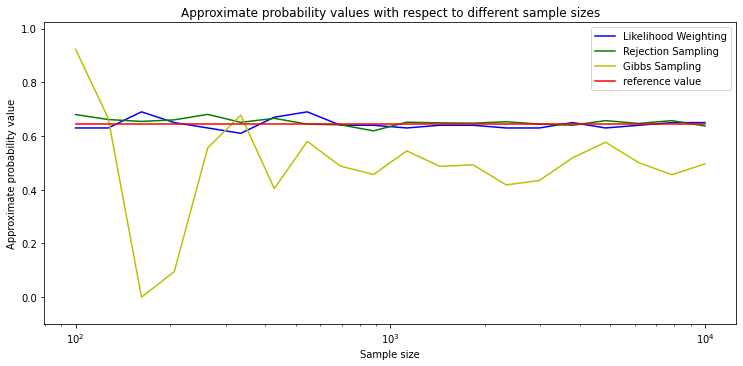

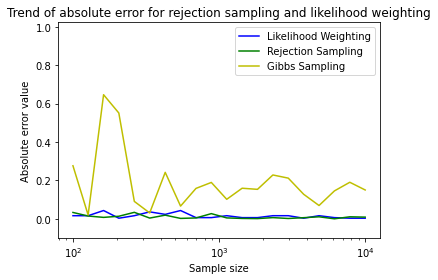

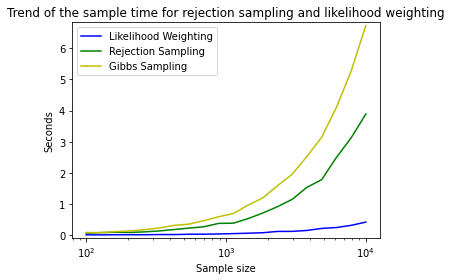

In [38]:
#P(deployability|starter=True,penalty_kicker=True,home_match=False)
query_var = ['deployability']
query_evidence = {'starter':True,'penalty_kicker':True,'home_match':False}
value=True
approximate_inference(query_var,query_evidence,value)

In [ ]:
print("\n P(goal|score_range='>=10')")
query_var = ['goal']
query_evidence = {'score_range': '>=10'}
value=True
approximate_inference(query_var,query_evidence,value)

In [ ]:
print("\n P(time_range|score_range='5.5-6.5')")
query_var = ['time_range']
query_evidence = {'score_range': '>=10'}
value='0-15'
approximate_inference(query_var,query_evidence,value)
